(150, 4)
(150,)




/usr/local/Anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1687: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/Anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1687: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


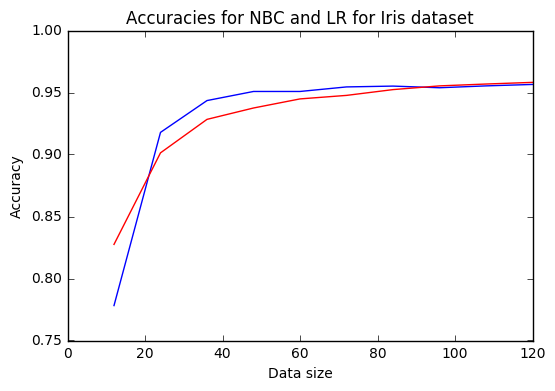

(232, 16)
(232,)




/usr/local/Anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:98: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/Anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:98: RuntimeWarning: divide by zero encountered in log


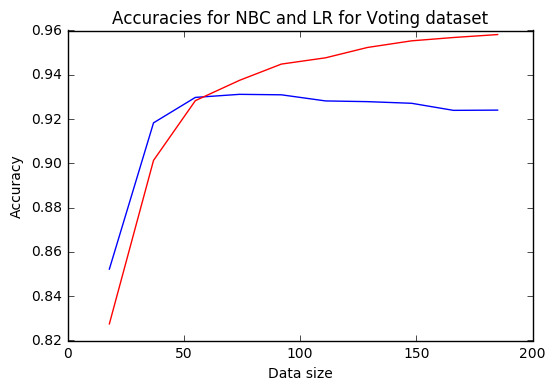

(435, 16)
(435,)




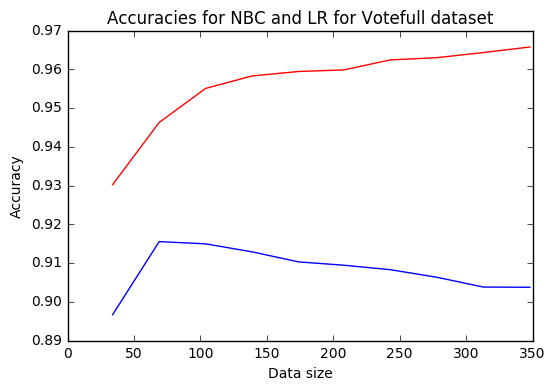

In [1]:
import cPickle as cp
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sci

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer

# NAIVE BAYES CLASSIFIER CLASS
class NBC:
    
    # Initialisation
    def __init__(self, feature_types=0, num_classes=0):
        self.feature_types = feature_types
        self.num_classes = num_classes
        self.theta = 0
        self.pi = 0
        
    def fit(self, X_train, Y_train):
        
        # Setting classes, number of datapoints, and pi and theta dictionaries
        Y_classes = np.unique(Y_train)
        N, _ = X_train.shape
        pi = {}
        theta = {}
        
        # Loops over classes
        for cls in Y_classes:
            
            # Index tells us the rows which result in current class
            index = Y_train == cls
            
            # Setting the class probability
            pi[cls] = float(np.sum(Y_train == cls)) / N
            
            # Theta is a dictionary that holds probability distribution for each class and feature
            theta[cls] = range(np.size(self.feature_types))
            
            # Isolating the rows which result in current class
            X_cls = X_train[index]
            
            for i in range(np.size(self.feature_types)):
                
                # If the feature is binary it will just hold 1-mean (probability of 0) and mean (probability of 1)
                if self.feature_types[i] == 'b':
                    theta[cls][i] = np.zeros(3)
                    
                    # If value is unknown we give it probability 1
                    theta[cls][i][2] = 1
                    
                    N_2 = np.sum(X_cls[:,i].astype(np.float) == 2)
                    N_full = np.size(X_cls[:,i])
                    
                    # Calculating probability so that it excludes any missing values
                    if N_2 != N_full:
                        theta[cls][i][0] = 1 - (float(np.sum(X_cls[:,i].astype(np.float) == 1)) / (N_full - N_2))
                        theta[cls][i][1] = float(np.sum(X_cls[:,i].astype(np.float) == 1)) / (N_full - N_2)
                        
                    # If all values are missing just set probs to 0.5
                    else:
                        theta[cls][i][0] = 0.5
                        theta[cls][i][1] = 0.5     
                
                # If the feature is real it will hold mean and std for the distribution
                if self.feature_types[i] == 'r':
                    theta[cls][i] = np.zeros(2)
                    theta[cls][i][0] = np.mean(X_cls[:,i].astype(np.float))
                    theta[cls][i][1] = np.std(X_cls[:,i].astype(np.float))
                 
                # If the feature is categorical it will hold the probability of appearance for each category in feature
                if self.feature_types[i] == 'c':
                    theta[cls][i] = {}
                    for cat in np.unique(X_train[:,i]):
                            Nc, _ = X_cls.shape
                            cat_prob = np.sum(X_cls[:,i] == cat) / Nc
                            theta[cls][i][cat] = cat_prob
                                  
        self.theta = theta
        self.pi = pi
        
    def predict(self, X_test):
        N, _ = X_test.shape
        
        # Setting the prediction variable
        y_hat = np.chararray(N)
        
        for n in range(N):
            max_prob = -float('inf')
            cls_hat = 0
            
            for cls in self.pi:
                temp_prob = np.log(self.pi[cls])
                
                for feature in range(np.size(self.feature_types)):
                    
                    # Binary Features
                    if self.feature_types[feature] == 'b':
                        temp_prob += np.log(self.theta[cls][feature][X_test[n, feature]])
                        
                    # Real Features
                    if self.feature_types[feature] == 'r':
                        temp_prob += sci.norm.logpdf(X_test[n, feature].astype(np.float), self.theta[cls][feature][0], self.theta[cls][feature][1])
                    
                    # Categorical Features
                    if self.feature_types[feature] == 'c':
                        temp_prob += np.log(self.theta[cls][feature][X_test[n, feature]])
                        
                if temp_prob >= max_prob:
                    max_prob = temp_prob
                    cls_hat = cls
            
            y_hat[n] = cls_hat
            y_hat = np.array(map(str, y_hat))
        
        return y_hat

# Loading Iris Dataset
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

print(np.shape(X))
print(np.shape(y))
print('\n')

# Setting number of repetitions
reps=200

nbc_accuracy = np.zeros((reps, 10))
logreg_accuracy = np.zeros((reps, 10))
datapoints = np.zeros(10)

# Declaring Classifiers
nbc_iris = NBC(['r','r','r','r'], 3)
logreg_iris = LogisticRegression(C = 5.0)

# Loop over repetitions
for i in range(reps):

    N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    # Setting output to NBC return format so they can be compared
    ytest_nbc=np.array(map(str, ytest))

    # Loop over increments of data
    for j in range(10):
        
        Nbatch = int(0.1 * (j+1) * Ntrain)
        Xbatch = Xtrain[:Nbatch]
        ybatch = ytrain[:Nbatch]
        
        datapoints[j]=Nbatch
        
        nbc_iris.fit(Xbatch, ybatch)
        y_hat = nbc_iris.predict(Xtest)
        nbc_accuracy[i, j] = np.mean(y_hat == ytest_nbc)
        
        logreg_iris.fit(Xbatch,ybatch)
        y_hat = logreg_iris.predict(Xtest)
        logreg_accuracy[i, j] = np.mean(y_hat == ytest)
        
nbc_accuracy_average=np.mean(nbc_accuracy, axis=0)
logreg_accuracy_average=np.mean(logreg_accuracy, axis=0)

plt.plot(datapoints, nbc_accuracy_average, 'b', datapoints, logreg_accuracy_average, 'r')
plt.title('Accuracies for NBC and LR for Iris dataset')
plt.xlabel('Data size')
plt.ylabel('Accuracy')
plt.show()

# Loading Voting Dataset
X, y = cp.load(open('voting.cPickle','rb'))

print(np.shape(X))
print(np.shape(y))
print('\n')

nbc_accuracy = np.zeros((reps, 10))
logreg_accuracy = np.zeros((reps, 10))
datapoints = np.zeros(10)

# Declaring Classifiers
nbc_vote = NBC(['b','b','b','b','b','b','b','b','b','b','b','b','b','b','b','b'], 2)
logreg_vote = LogisticRegression(C = 5.0)

for i in range(reps):

    N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    # Setting output to NBC return format so they can be compared
    ytest_nbc=np.array(map(str, ytest.astype(np.int)))

    for j in range(10):
        
        Nbatch = int(0.1 * (j+1) * Ntrain)
        Xbatch = Xtrain[:Nbatch]
        ybatch = ytrain[:Nbatch]
        
        datapoints[j]=Nbatch
        
        nbc_vote.fit(Xbatch, ybatch)
        y_hat = nbc_vote.predict(Xtest)
        nbc_accuracy[i, j] = np.mean(y_hat == ytest_nbc)
        
        logreg_vote.fit(Xbatch,ybatch)
        y_hat = logreg_vote.predict(Xtest)
        logreg_accuracy[i, j] = np.mean(y_hat == ytest)
        
nbc_accuracy_average=np.mean(nbc_accuracy, axis=0)
lognreg_accuracy_average=np.mean(logreg_accuracy, axis=0)

plt.plot(datapoints, nbc_accuracy_average, 'b', datapoints, logreg_accuracy_average, 'r')
plt.title('Accuracies for NBC and LR for Voting dataset')
plt.xlabel('Data size')
plt.ylabel('Accuracy')
plt.show()

# Loading Voting Full Dataset
X, y = cp.load(open('voting-full.cPickle', 'rb'))

print(np.shape(X))
print(np.shape(y))
print('\n')

nbc_accuracy = np.zeros((reps, 10))
logreg_accuracy = np.zeros((reps, 10))
datapoints = np.zeros(10)

# Declaring classifiers
nbc_votefull = NBC(['b','b','b','b','b','b','b','b','b','b','b','b','b','b','b','b'], 2)
logreg_votefull = LogisticRegression(C = 5.0)

imp = Imputer(missing_values=2, strategy='mean', axis=0)

for i in range(reps):

    N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    # Setting output to NBC return format so they can be compared
    ytest_nbc=np.array(map(str, ytest.astype(np.int)))

    for j in range(10):
        
        Nbatch = int(0.1 * (j+1) * Ntrain)
        Xbatch = Xtrain[:Nbatch]
        ybatch = ytrain[:Nbatch]
        
        datapoints[j]=Nbatch
        
        nbc_votefull.fit(Xbatch, ybatch)
        y_hat = nbc_votefull.predict(Xtest)
        nbc_accuracy[i, j] = np.mean(y_hat == ytest_nbc)
        
        imp.fit(Xbatch)
        
        logreg_votefull.fit(imp.transform(Xbatch),ybatch)
        y_hat = logreg_votefull.predict(imp.transform(Xtest))
        logreg_accuracy[i, j] = np.mean(y_hat == ytest)
        
nbc_accuracy_average=np.mean(nbc_accuracy, axis=0)
logreg_accuracy_average=np.mean(logreg_accuracy, axis=0)

plt.plot(datapoints, nbc_accuracy_average, 'b', datapoints, logreg_accuracy_average, 'r')
plt.title('Accuracies for NBC and LR for Votefull dataset')
plt.xlabel('Data size')
plt.ylabel('Accuracy')
plt.show()

In [12]:
import numpy as np

theta={}
theta['first']=range(16)
print(theta)
theta['first'][0]={}
theta['first'][0]['bla']=0.5
theta['first'][0]['cla']=0.7
theta['first'][0]['dla']=1
print(theta)
theta['first'][1]=np.zeros(2)
theta['first'][1][0]=4
theta['first'][1][1]=1.5
theta['first'][2]=0.3
theta

{'first': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}
{'first': [{'dla': 1, 'bla': 0.5, 'cla': 0.7}, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}


{'first': [{'bla': 0.5, 'cla': 0.7, 'dla': 1},
  array([ 4. ,  1.5]),
  0.3,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15]}